# Amazon Mechanical Turk

The role of this script is to generate the data in a format that we can use to label on Mechanical Turk

1. Generate the next batch
2. Read the batch and write it to MongoDB

In [58]:
from data.dao import DataAccess, LabelGetter
from data.turk import TurkResults2Label

import pandas as pd
import datetime
import re
import pickle
import numpy

%matplotlib inline

Getting the data from DataAccess is so easy!

In [3]:
%%time

X = DataAccess.get_not_labeled().sort("random_number")
X.head(10)

CPU times: user 3.79 s, sys: 5.14 s, total: 8.93 s
Wall time: 14.1 s


In [5]:
X_filter = X[X.control != 1]
X_filter.head()

,control,predict,random_number,text
_id,,,,
556e8debd6dfbb3061976b0e,NaN,0.215714,0.004196,My #TeenChoice nominee for #ChoiceMaleWebStar ...
5575d384d6dfbb66f9dac606,NaN,0.194029,0.004235,#TweetMyJobs #Accounting #Job alert: Senior Ac...
5572131ed6dfbb33bf90487d,NaN,0.338928,0.004239,"Never imagined myself saying this 3 years ago,..."
5572b598d6dfbb719b60fb40,NaN,0.411088,0.004250,Who made me drink &amp; why?
557849c1d6dfbb56c0b31675,NaN,0.258357,0.004261,".@BilldeBlasio Opposes Linking Tax Credit, Ren..."


In [6]:
X_control = X[X.control == 1]
X_control.head()

,control,predict,random_number,text
_id,,,,
5570b291d6dfbb2a5bc472ad,1,NaN,0.056435,bein sober suhks donkey dicc 😒 how tf do yall ...
558ec67dd6dfbb2c4959af07,1,NaN,0.068267,Beak and Skiff...we're here for the alcohol:-)...
5576379ad6dfbb240cd126c3,1,NaN,0.074667,so they are kinda my best friends.... #Nationa...
556ba147d6dfbb336fb8b5e3,1,NaN,0.075107,Shut it down? I'm just getting started... (Und...
5589bc5ed6dfbb0dcfb432c4,1,NaN,NaN,@ShaneOtheInsanO @itsAlexSMITH check out my ho...


# Preprocessing

In [9]:
from __private import fs
from classification.dao import ClassifierAccess

In [8]:
fs.list()

['alcohol|accuracy:0.8010471204188482|f1:0.82389289392379|type:SVC',
 'alcohol|accuracy:0.8144269924374636|f1:0.8344577062791905|type:SVC',
 'alcohol|accuracy:0.8237347294938918|f1:0.8478151682571572|type:SVC',
 'alcohol|accuracy:0.8289703315881326|f1:0.8509127789046653|type:SVC',
 'alcohol|accuracy:0.8301337987201861|f1:0.8513238289205702|type:RandomForestClassifier',
 'first_person_label|accuracy:0.52046783625731|f1:0.5009187878453114|type:SVC',
 'first_person_label|accuracy:0.5243664717348928|f1:0.508797109912656|type:RandomForestClassifier',
 'first_person_label|accuracy:0.530214424951267|f1:0.5136580488488517|type:SVC',
 'first_person_label|accuracy:0.5321637426900585|f1:0.5265047952844989|type:LogisticRegression',
 'first_person_label|accuracy:0.543859649122807|f1:0.5166687798266746|type:SVC',
 'first_person_label|accuracy:0.5536062378167641|f1:0.5349297830780407|type:SVC',
 'first_person_label|accuracy:0.5555555555555556|f1:0.53459052797563|type:RandomForestClassifier',
 'first_

In [13]:
clf_fp = ClassifierAccess.get_byfile("first_person|accuracy:0.6947637292464879|f1:0.7941429801894918|type:SVC")

In [14]:
clf_ac = ClassifierAccess.get_byfile("alcohol|accuracy:0.8289703315881326|f1:0.8509127789046653|type:SVC")

In [15]:
first_person_labels = clf_fp.predict_proba(X_control)[:,1]
alch_labels = clf_ac.predict_proba(X_control)[:,1]

In [17]:
X_control["predicted_fp"] = first_person_labels
X_control["predicted_alc"] = alch_labels

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [37]:
X = X_control[(X_control.predicted_fp > 0.5) & (X_control.predicted_alc > 0.6) & ~(X_control.text.str.contains("Drinking a"))]

In [38]:
X["score"] = (X.predicted_alc * X.predicted_fp)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [95]:
X

,control,predict,random_number,text,predicted_fp,predicted_alc,score
_id,,,,,,,
55751f3dd6dfbb6af2f468a1,1,NaN,0.187861,If u need help on how 2 be a 17yr old boy w/ s...,0.507546,0.788339,0.400118
55703f4bd6dfbb65d49d0703,1,NaN,0.187861,@TheWorlds50Best Swimming Ayu on a charcoal gr...,0.515718,0.775895,0.400143
55890819d6dfbb577a0c9ba7,1,NaN,0.187861,Happy birthday to my mom and the Madison Beer ...,0.620014,0.645465,0.400197
5589d501d6dfbb1199c41daa,1,NaN,0.187861,@mcspocky @ginou1010 I would like to think som...,0.658119,0.608099,0.400201
5588113cd6dfbb69f989351e,1,NaN,0.187861,This weds big birthday celebration for glitter...,0.551120,0.726733,0.400517
558ce810d6dfbb77017ca246,1,NaN,0.187861,@paletapayasoo can't wait till Saturday bby 😆....,0.655877,0.610809,0.400615
557b8a90d6dfbb4db1fd0a4a,1,NaN,0.187861,An amazing appetizer cocktail by mad scientist...,0.628386,0.637940,0.400872
5583013ed6dfbb6115efe5be,1,NaN,0.187861,@dallasgunzales he was the one who gave them t...,0.628796,0.637790,0.401040
5573da14d6dfbb61b92c8202,1,NaN,0.187861,#polo #Breitling #teambreitling #realmenwearpi...,0.534407,0.750635,0.401145


In [39]:
%matplotlib inline

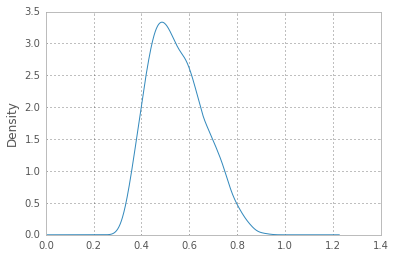

In [40]:
X.score.plot("kde")

In [98]:
X = X[(X.score > 0.5) & (X.predicted_fp > 0.6)].sort("score")

In [104]:
X.random_number = X.text.apply(hash)

In [110]:
X

,control,predict,random_number,text,predicted_fp,predicted_alc,score
_id,,,,,,,
556c3ec9d6dfbb63a081173c,1,NaN,-834399541597594731,@CorwinHall1 lol I'm sick so I can't drink coffee,0.773663,0.646277,0.500001
5588e7add6dfbb4c4680037d,1,NaN,-2846109381417569355,I love how in #Blackwater Cersei gets hammered...,0.644087,0.777230,0.500604
55751846d6dfbb6af2f411ab,1,NaN,2645781735439479791,Even though I may have drank a few too much @C...,0.781330,0.640772,0.500654
556c9d69d6dfbb0454c18194,1,NaN,1986767390469275942,Drinking game: Take a shot every time you come...,0.634611,0.789016,0.500718
557fb5b8d6dfbb039cb75401,1,NaN,6095745891679269334,"Mom gave me this, and lowkey out of everything...",0.773300,0.647903,0.501023
558a1e59d6dfbb28e5427234,1,NaN,-9183111092159800126,Gonna take a mean ass shit since I drank cranb...,0.780951,0.642033,0.501397
5584ec15d6dfbb72710de15d,1,NaN,-2210598740367079636,Bama will be real. So glad I met you on the ai...,0.673590,0.744944,0.501786
556cafb7d6dfbb143056bb40,1,NaN,4947023027255162911,A3: Probably my youngest! I'm pretty sure sh'e...,0.650065,0.771911,0.501793
556d2f79d6dfbb40dd51e389,1,NaN,3597349294531921536,Hiding your pain away with alcohol is not an a...,0.600968,0.835745,0.502256


# Generating...

In [116]:
date = str(datetime.date.today())
candidate = X.sort("random_number").head(800)
key = candidate.random_number.sum()

In [117]:
candidate["text"] = candidate.text.str.encode("utf-8")

In [118]:
candidate[["text", "random_number"]].to_csv(
    "../amt/c_amt|{}|{}.csv".format(date, key),
)

In [119]:
%%bash

ls ../amt/

Batch_2055156_batch_results.csv
Batch_2064123_batch_results.csv
Batch_2064125_batch_results.csv
Batch_2101169_batch_results.csv
Batch_2164917_batch_results.csv
amt_2015-08-13_4952308500878643456.csv
amt_2015-08-17_2546340314496401664.csv
amt_2015-08-20_8806137010034599936.csv
amt_2015-09-10_6072541214091395328.csv
amt_2015-09-24_-7976654553505407232.csv
amt|2015-09-10|6072541214091395328.csv
amt|2015-09-24|-7976654553505407232.csv
amt|2015-11-16|-6308615403510686754.csv
amt|2015-11-16|-81244987503678735.csv
amt|2015-11-16|287544318312245760.csv
c_amt_2015-11-16_-6269207037782773504.csv
c_amt|2015-11-16|7954396760112903981.csv


In [120]:
%%bash

open .. 

# Parsing to Label

#### New Labels

Straight from Amazon Mechanical Turk

In [122]:
df = pd.DataFrame.from_csv("../amt/Batch_2166655_batch_results.csv")

In [124]:
df.Worker.value_counts().head(10)

A38K3QQPV8CTPC    185
A2R0YYUAWNT7UD    151
A1DZLZE63NE1ZI     91
A9KPCMO1J1LQF      63
ABOEYY9Y0PFRI      61
A2XFGTPDO4KQ2B     38
A3749HUHYLI50L     34
A2ESBX4C2Q6TQY     34
A1EITLFAMKA61U     27
A6U5ZHN5Y953Q      22
dtype: int64

In [140]:
worker = lambda w: df[df.Worker == w]#.Answer.value_counts()# / df[df.Worker == w].Answer.value_counts().sum()

First Person - Alcohol::Reflecting on drinking    0.227273
Alcohol Related::Discussion                       0.227273
First Person - Alcohol::Looking to drink          0.181818
Not Alcohol Related                               0.136364
Alcohol Related::Promotional Content              0.136364
First Person - Alcohol::Heavy Drinking            0.045455
First Person - Alcohol::Casual Drinking           0.045455
dtype: float64

In [146]:
worker("A2R0YYUAWNT7UD").sample(50)[["text", "Answer"]]

,text,Answer
HITID,,
36U4VBVNQOX3KGT5OL319D96X0CURV,b'@MobShitAj You drunk if you think you look b...,Alcohol Related::Discussion
3ZTE0JGGCEC419KPA21XLCIVFDLOC6,"b""I can't listen to pass me the green. It make...",First Person - Alcohol::Casual Drinking
3T2EL38U0M4VPJ80GBPOOUY5VWRXQP,b'@dylanscott how many fathers days wishes do ...,First Person - Alcohol::Casual Drinking
338431Z1FLZ87B98SZRSA7HHFEOROF,"b""@quixoticideal he's going to catch feelings ...",First Person - Alcohol::Casual Drinking
3LG268AV38QMVKWJYLOW5VN3BCIREB,b'seltzer with a lime = favorite. Loving the ...,First Person - Alcohol::Casual Drinking
3XAOZ9UYRZBNZIN79I4HTLU4QHDQ1R,b'Saturday - to life! rosenblumcoloredglasses ...,Not Alcohol Related
3AXFSPQOYQIX3AD2LRZTLMMCDW3JFT,"b'@MgtyMicroscope Yeah, ABV is getting to be a...",First Person - Alcohol::Casual Drinking
3W1K7D6QSB1XQ86QYBGJQQJHHWOZBC,b'Chelsea and Liv do life. #wine #NYC #friends...,First Person - Alcohol::Casual Drinking
30EV7DWJTVFRF6FQ6YXS13ONX1A6Y8,b'Brewery in a meadow. #literally #sunset #wil...,Not Alcohol Related


In [147]:
df = df[(df.Answer != "{}") & 
        (df.Answer != "Alcohol Related") &
        (df.Answer != "First Person - Alcohol")]

df = df[df.Worker != "A2R0YYUAWNT7UD"]
df.Answer.value_counts() / df.Answer.value_counts().sum()

Alcohol Related::Discussion                       0.291473
First Person - Alcohol::Looking to drink          0.189147
First Person - Alcohol::Casual Drinking           0.156589
Not Alcohol Related                               0.153488
First Person - Alcohol::Reflecting on drinking    0.110078
Alcohol Related::Promotional Content              0.065116
First Person - Alcohol::Heavy Drinking            0.034109
dtype: float64

In [153]:
df.iloc[12]

_id                                       5591bc89d6dfbb71733a4e78
text             b'@XenCOD u down to play beer pong with  Casey...
random_number                                          -2.7863e+18
Worker                                               A9KPCMO1J1LQF
Answer                    First Person - Alcohol::Looking to drink
Date                                       2015-11-17 03:43:03 UTC
Name: 3DIIW4IV8PFRAJW7JSIAIHALBR64IF, dtype: object

#### Writing Labels using TurkResults2Label

In [150]:
%%time
DataAccess.write_labels(df.Answer.apply(TurkResults2Label.parse_to_labels))

CPU times: user 555 ms, sys: 214 ms, total: 770 ms
Wall time: 28.2 s


In [152]:
from __private import db